In [25]:
!pip install pandas scikit-learn implicit numpy seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 35.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.9/303.9 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 44.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 37.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 34.3 MB/s eta 0:00:00


In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Carregamos o dataset e printamos todas as colunas e seu respectivo tipo.

In [4]:
# Carregar o dataset
dataset_path = 'laptops_info.csv'
laptops_df = pd.read_csv(dataset_path)

# Visualizar as primeiras linhas do dataset
laptops_df.head()

,brand,laptop_name,display_size,processor_type,graphics_card,disk_space,discount_price,old_price,ratings_5max
0,HP,Notebook 14-df0008nx,14.0,Intel Celeron N4000,Intel HD Graphics 600,64 GB (eMMC),1259.0,1259.0,0 / 5
1,Lenovo,IdeaPad 330S-14IKB,14.0,Intel Core i5-8250U,Intel UHD Graphics 620,1 TB HDD,1849.0,2099.0,3.3 / 5
2,Huawei,MateBook D Volta,14.0,Intel Core i5-8250U,NVIDIA GeForce MX150 (2 GB),256 GB SSD,2999.0,3799.0,0 / 5
3,Dell,Inspiron 15 3567,15.6,Intel Core i3-7020U,Intel HD Graphics 620,1 TB HDD,1849.0,1849.0,0 / 5
4,Asus,VivoBook 15 X510UR,15.6,Intel Core i7-8550U,NVIDIA GeForce 930MX (2 GB),1 TB HDD,2499.0,3149.0,0 / 5


Aqui, como a coluna 'rating_5max' está como string, criamos uma nova coluna chamada 'rating_float' que transforma os valores de avaliação em números floats, para ficar mais fácil de manusear o dataset.

In [5]:
# Extrair o número da avaliação
laptops_df["rating_float"] = laptops_df["ratings_5max"].str.split("/").str[0]

# Converter para float
laptops_df["rating_float"] = laptops_df["rating_float"].astype(float)

---------------------------------------------------------------------------

É importante também entendermos como está a distribuição das avaliações. A maioria dos laptops estão com avaliação 0.0 (cremos que seja por conta do produto não ter sido avaliado), mas isso não deixa nossa análise menos justa, tendo em vista que vamos usar outros parâmetros para construção do sistema de recomendação.

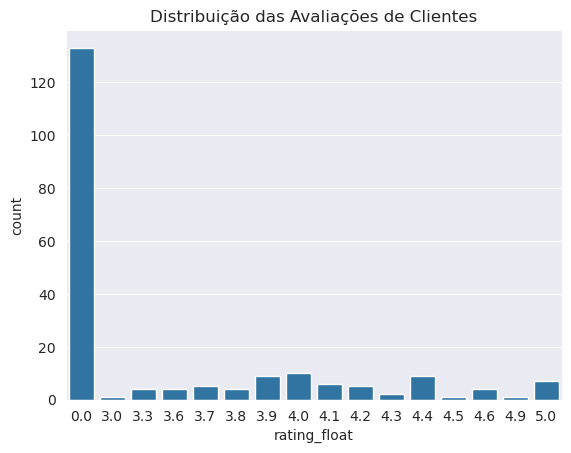

In [6]:
# Distribuição das avaliações de clientes
sns.countplot(x='rating_float', data=laptops_df)
plt.title('Distribuição das Avaliações de Clientes')
plt.show()

Nesse plot abaixo, temos a quantidade de laptops dentro do nosso dataset separados pela marca, para termos noção da distribuição.

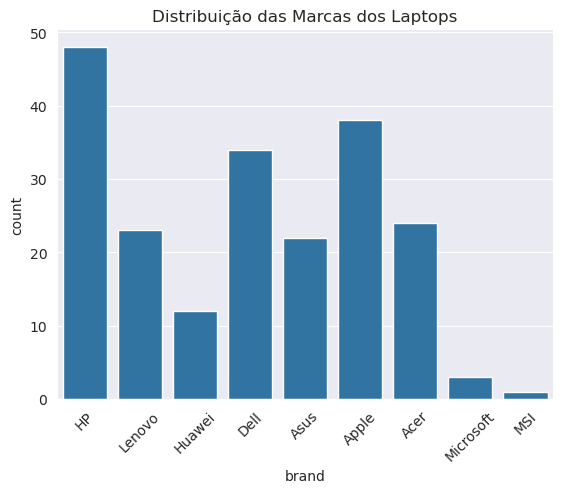

In [7]:
# Distribuição das marcas dos laptops
sns.countplot(x='brand', data=laptops_df)
plt.title('Distribuição das Marcas dos Laptops')
plt.xticks(rotation=45)
plt.show()

Esse gráfico abaixo plota a quantidade de avaliações por marca. Combinando os dois últimos gráficos, temos uma definição que faz sentido: os laptops da marca 'HP' (que é a marca com mais produtos dentro do dataset) foram os que mais foram avaliados. 

/tmp/ipykernel_7407/2353000012.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, avaliacoes_por_marca[i], avaliacoes_por_marca[i], ha='center', va='bottom')


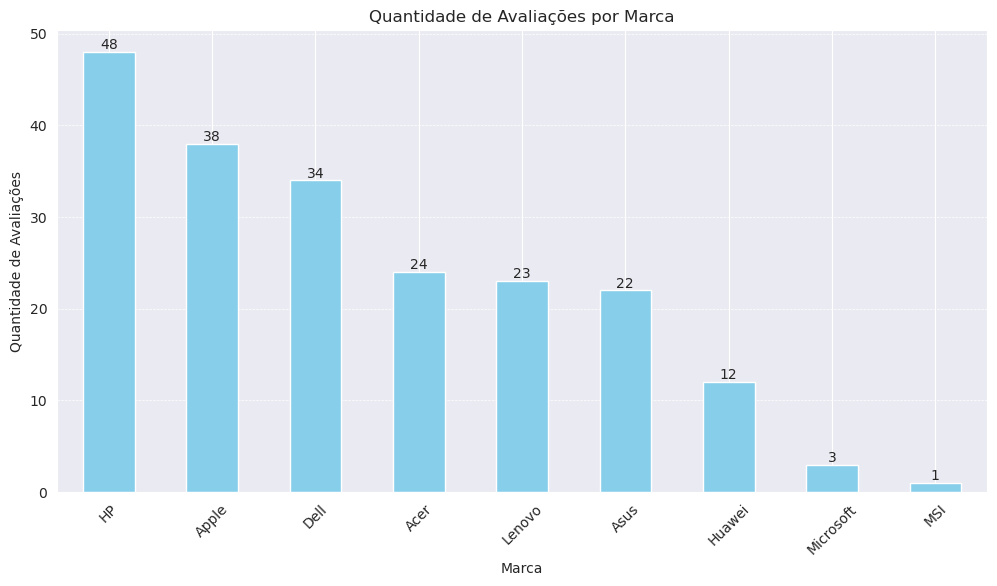

In [8]:
# Contar a quantidade de avaliações por marca
avaliacoes_por_marca = laptops_df['brand'].value_counts()

# Plotar um gráfico de barras com as marcas mais avaliadas
plt.figure(figsize=(12, 6))
avaliacoes_por_marca.plot(kind='bar', color='skyblue')
plt.title('Quantidade de Avaliações por Marca')
plt.xlabel('Marca')
plt.ylabel('Quantidade de Avaliações')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5)

# Adicionar os valores das barras no gráfico
for i in range(len(avaliacoes_por_marca)):
    plt.text(i, avaliacoes_por_marca[i], avaliacoes_por_marca[i], ha='center', va='bottom')
    
plt.show()

Agora, vamos gerar um sistema de recomendação utilizando como colunas de interesse 'brand', 'discount_price' e 'rating'.

In [12]:
# Importando as bibliotecas necessárias
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Combinando as colunas de interesse em uma única coluna
laptops_df['content'] = laptops_df[['brand', 'discount_price', 'rating_float']].astype(str).apply(lambda x: ' '.join(x), axis=1)

# Calculando a matriz TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(laptops_df['content'])

In [17]:
# Calculando a matriz de similaridade
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Função para obter as recomendações
def get_recommendations(idx, cosine_sim=cosine_sim):
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    laptop_indices = [i[0] for i in sim_scores]
    return laptops_df['laptop_name'].iloc[laptop_indices]  # use df instead of laptop_indices

# Testando a função de recomendação
print(get_recommendations(0))

24     Pavilion 14-ce0001nx
26     Pavilion 14-ce0000nx
167             15-da0035nx
10              15-db0001nx
34     Pavilion 14-ce2000nx
Name: laptop_name, dtype: object


Como podemos ver pelo resultado acima, todos os notebooks indicados foram da marca HP. Isso mostra que, para as colunas de interesse escolhidas, o sistema de recomendação só está escolhendo laptops da marca HP. 

In [21]:
# Função para obter as recomendações
def get_recommendations_brand(idx, cosine_sim=cosine_sim):
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    laptop_indices = [i[0] for i in sim_scores]
    return laptops_df['brand'].iloc[laptop_indices]  # retorna as marcas dos laptops recomendados

# Obtendo as recomendações para todos os laptops
all_recommendations = []
for i in range(len(laptops_df)):
    all_recommendations.extend(get_recommendations_brand(i))

# Convertendo a lista de recomendações em uma Series do pandas
all_recommendations = pd.Series(all_recommendations)

# Contando a frequência de cada marca nas recomendações
brand_counts = all_recommendations.value_counts()

# Calculando a porcentagem de recomendação de cada marca
brand_percentage = brand_counts / len(all_recommendations) * 100

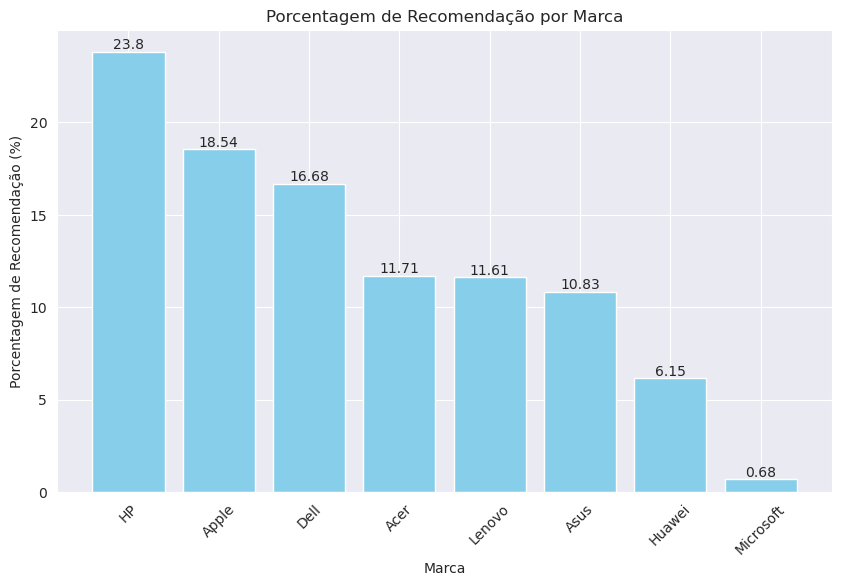

In [22]:
# Criando o gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(brand_percentage.index, brand_percentage.values, color='skyblue')

# Adicionando títulos e rótulos
plt.title('Porcentagem de Recomendação por Marca')
plt.xlabel('Marca')
plt.ylabel('Porcentagem de Recomendação (%)')

# Rotacionando os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45)

# Adicionando a porcentagem exata em cima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Exibindo o gráfico
plt.show()

In [35]:
# Função para obter as recomendações
def get_recommendations_branded(idx, cosine_sim=cosine_sim):
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    laptop_indices = [i[0] for i in sim_scores]
    return laptop_indices  # retorna os índices dos laptops recomendados

# Obtendo todas as recomendações
all_recommendations = []
for i in range(len(laptops_df)):
    all_recommendations.extend(get_recommendations_branded(i))

# Convertendo a lista de recomendações em uma Series do pandas
all_recommendations = pd.Series(all_recommendations)

# Obtendo as marcas dos laptops recomendados
recommended_brands = laptops_df['brand'].iloc[all_recommendations]

# Contando a frequência de cada marca nas recomendações para cada rating
recommendation_counts = laptops_df.loc[all_recommendations].groupby(['brand', 'rating_float'])['laptop_name'].count()

# Contando o total de laptops para cada marca e rating
total_counts = laptops_df.groupby(['brand', 'rating_float'])['laptop_name'].count()

# Calculando a métrica Equal Opportunity para cada marca e rating
equal_opportunity = recommendation_counts / total_counts

# Exibindo a métrica Equal Opportunity
print(equal_opportunity)

brand      rating_float
Acer       0.0              6.500000
           3.7              0.666667
           3.8              1.000000
           3.9                   NaN
           4.0                   NaN
Apple      0.0              9.500000
           3.9              1.333333
           4.0                   NaN
           4.3                   NaN
           4.4                   NaN
           4.5              1.000000
           4.6              2.500000
           4.9                   NaN
           5.0                   NaN
Asus       0.0              4.368421
           3.6             24.000000
           4.4              3.000000
           5.0              1.000000
Dell       0.0              4.708333
           3.3              1.000000
           3.7                   NaN
           3.8             27.000000
           4.0                   NaN
           4.3              1.000000
           4.4              0.666667
HP         0.0              4.057143
           3.0

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

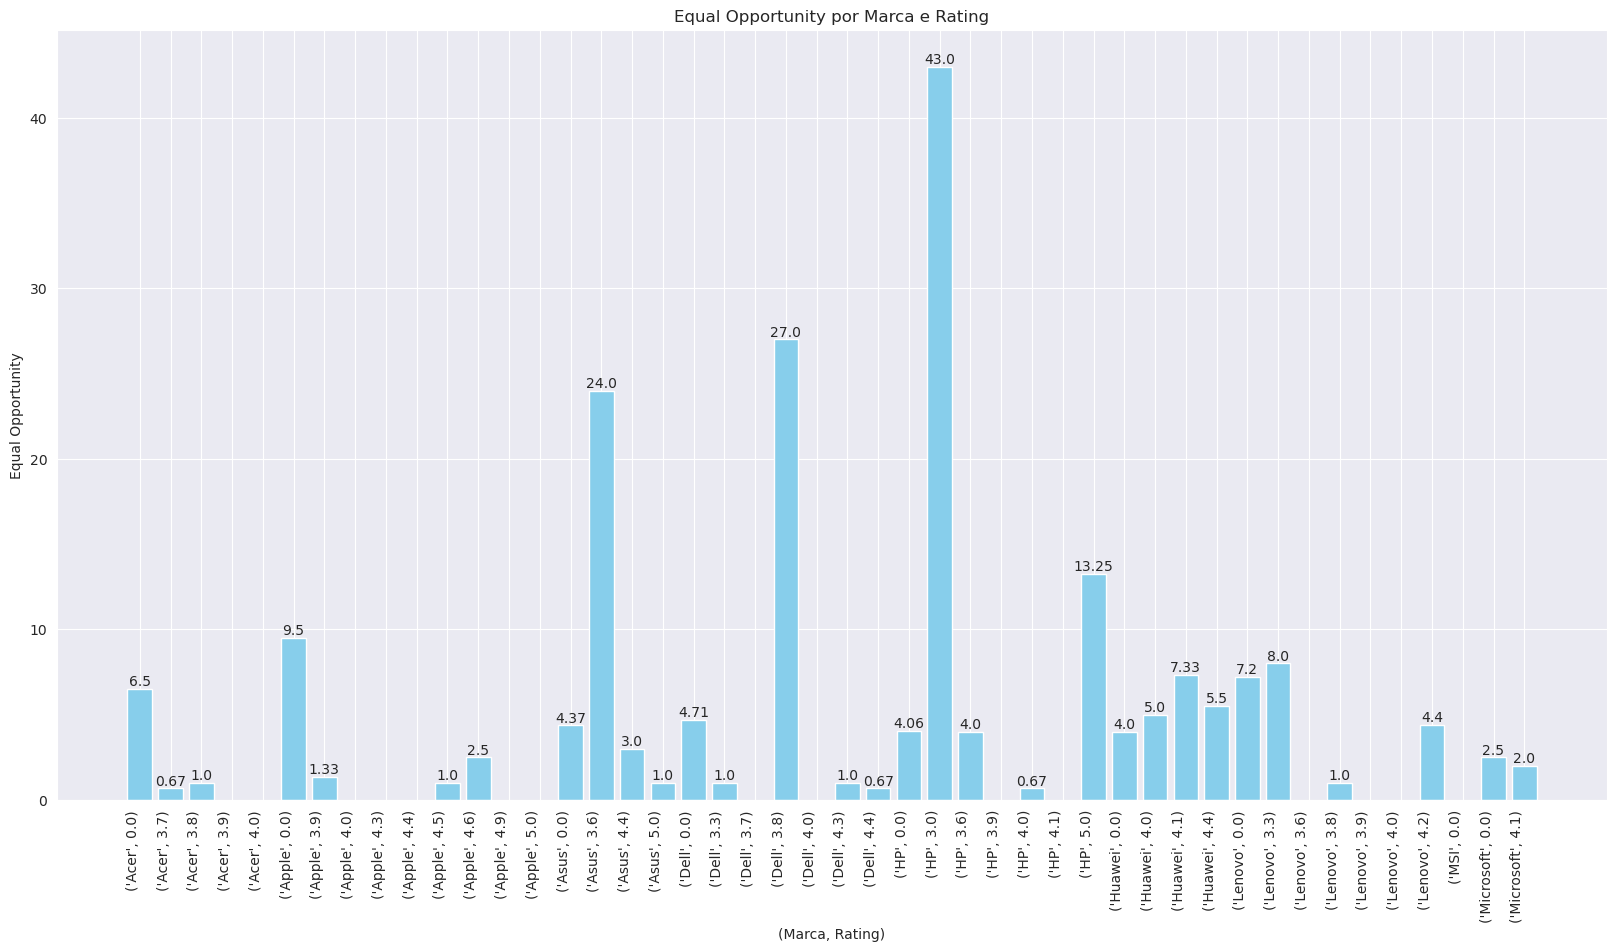

In [38]:
# Criando o gráfico de barras
plt.figure(figsize=(20, 10))  # aumenta o tamanho do gráfico
bars = plt.bar(equal_opportunity.index.map(str), equal_opportunity.values, color='skyblue')

# Adicionando títulos e rótulos
plt.title('Equal Opportunity por Marca e Rating')
plt.xlabel('(Marca, Rating)')
plt.ylabel('Equal Opportunity')

# Rotacionando os rótulos do eixo x para melhor visualização
plt.xticks(rotation=90, ha='right')  # adiciona mais espaço entre os rótulos

# Adicionando a porcentagem exata em cima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Exibindo o gráfico
plt.show()

In [75]:
# Agrupando os laptops por marca, rating e preço e contando quantas vezes cada um foi recomendado
recommendation_counts = laptops_df.loc[all_recommendations].groupby(['brand', 'discount_price'])['laptop_name'].count()

# Contando o total de laptops para cada marca, rating e preço
total_counts = laptops_df.groupby(['brand', 'discount_price'])['laptop_name'].count()

# Calculando a métrica Equalized Odds para cada marca, rating e preço
equalized_odds = recommendation_counts / total_counts

# Exibindo a métrica Equalized Odds
print(equalized_odds)


brand      discount_price
Acer       999.0              NaN
           1219.0             NaN
           1239.0             NaN
           1279.0             NaN
           1349.0             NaN
                             ... 
Lenovo     3599.0            16.0
MSI        9071.0             NaN
Microsoft  4199.0             NaN
           5399.0             1.0
           5799.0             NaN
Name: laptop_name, Length: 164, dtype: float64


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

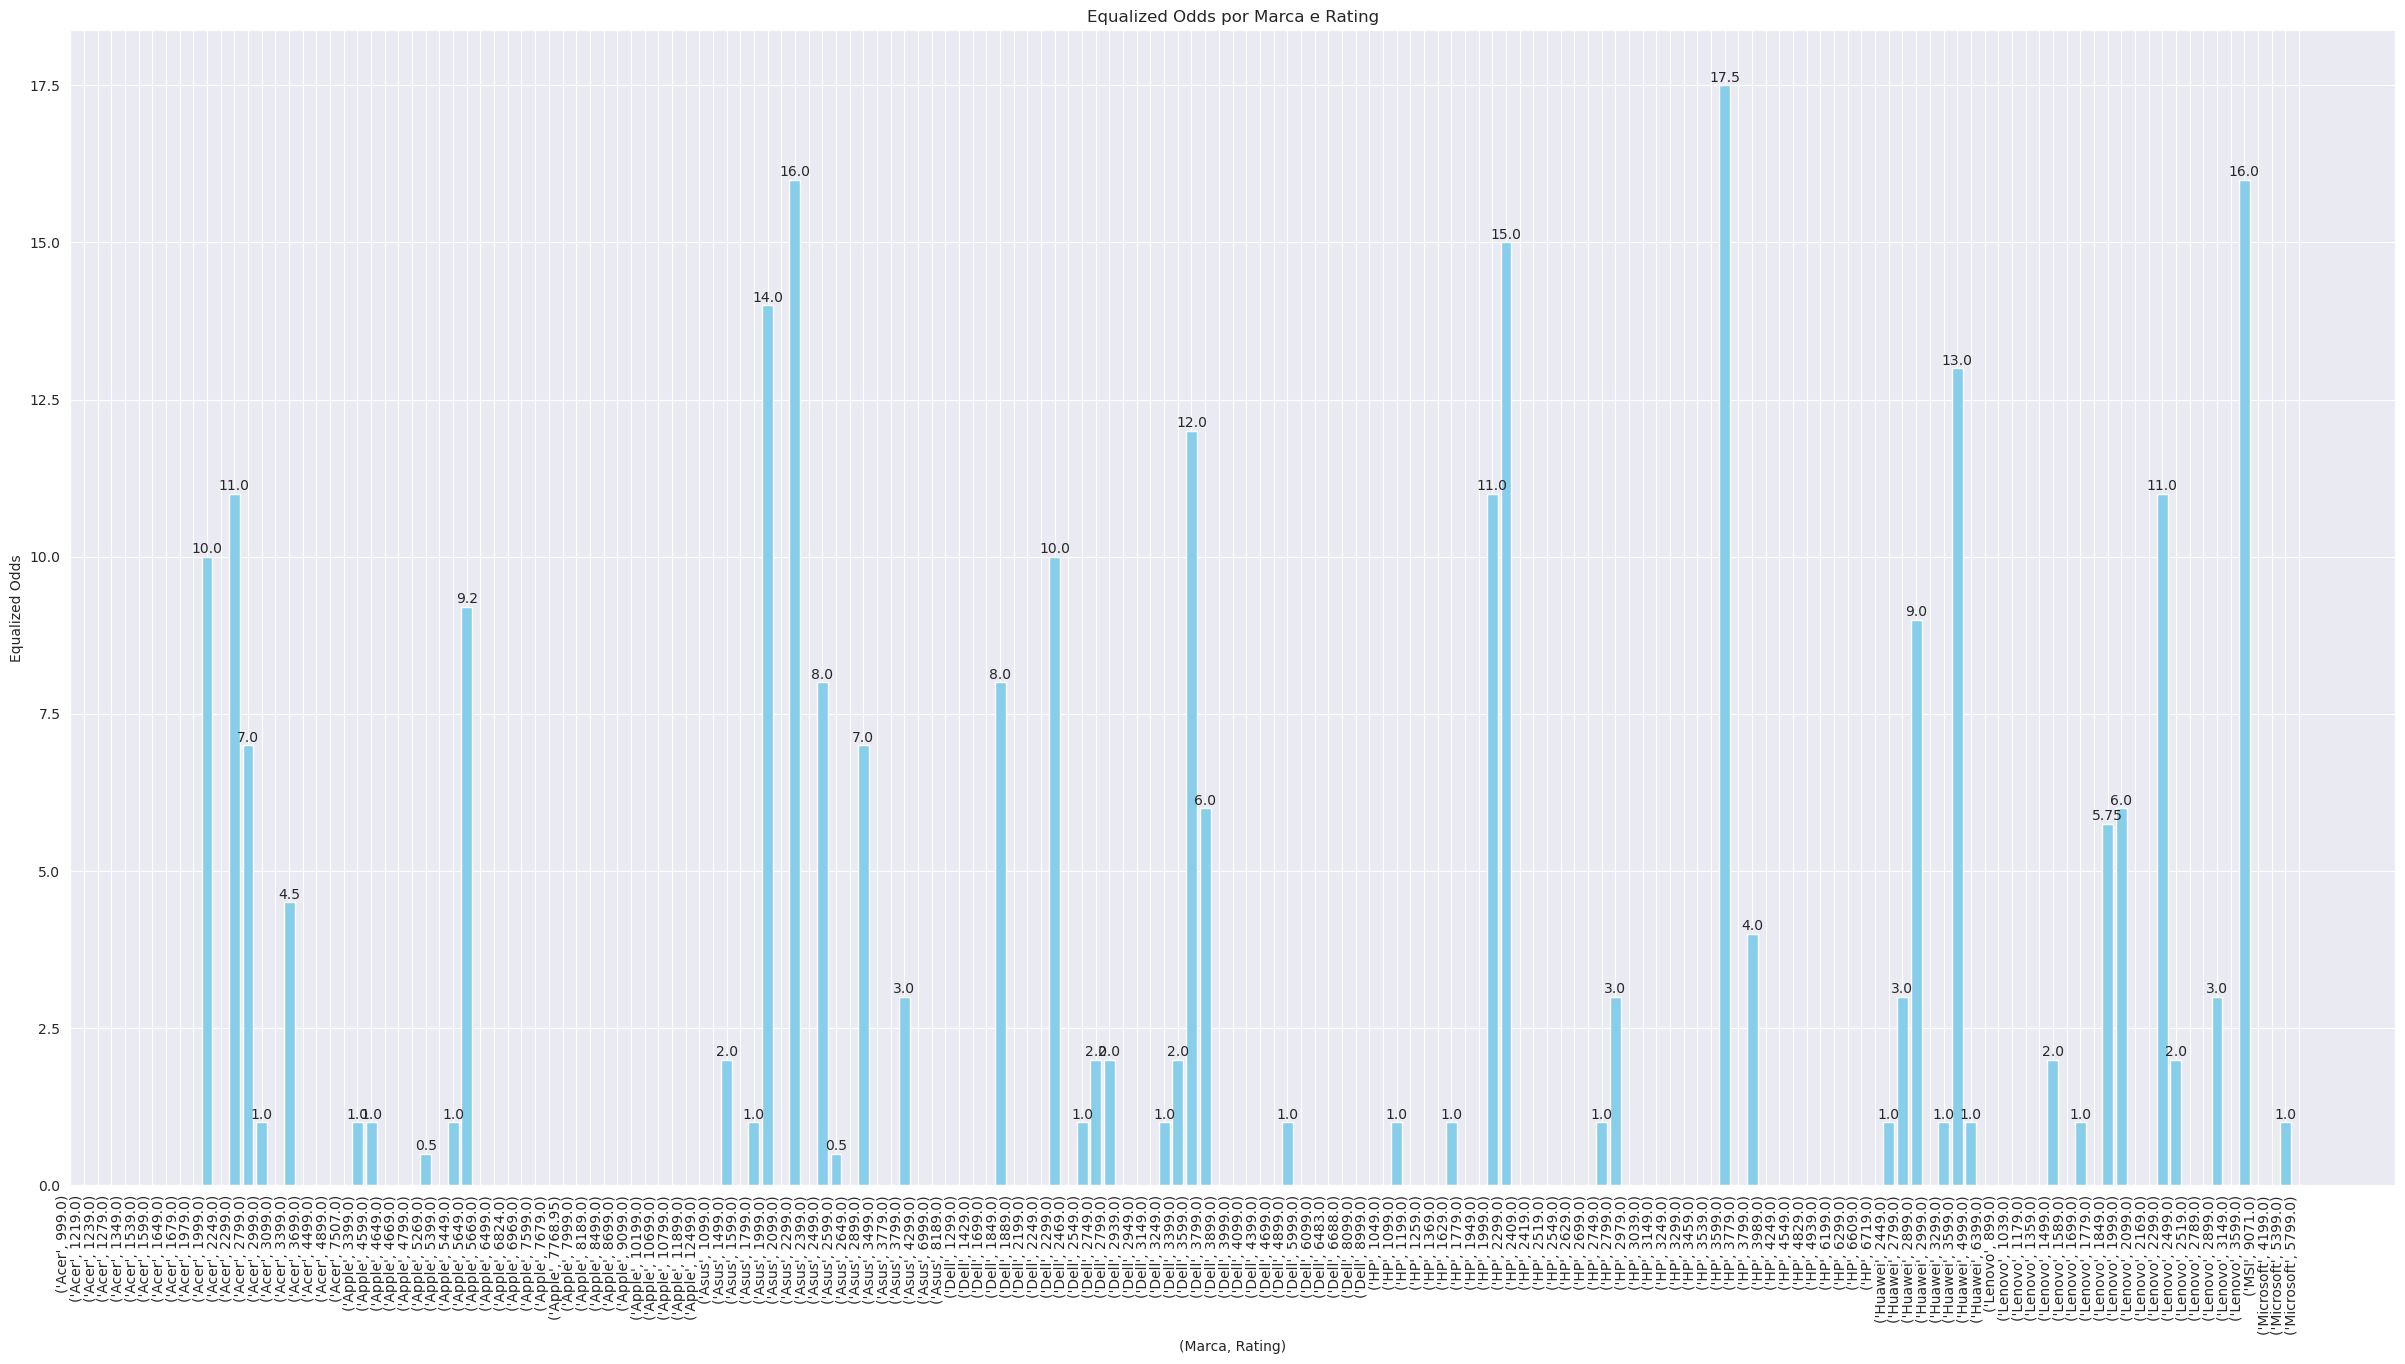

In [76]:
# Importando as bibliotecas necessárias
import matplotlib.pyplot as plt
import numpy as np

# Convertendo o índice em uma lista de strings para usar como rótulos do eixo x
x_labels = equalized_odds.index.map(str)

# Criando o gráfico de barras
plt.figure(figsize=(30, 15))  # aumenta o tamanho do gráfico
bars = plt.bar(np.arange(len(equalized_odds)), equalized_odds.values, color='skyblue')

# Adicionando títulos e rótulos
plt.title('Equalized Odds por Marca e Rating')
plt.xlabel('(Marca, Rating)')
plt.ylabel('Equalized Odds')

# Rotacionando os rótulos do eixo x para melhor visualização
plt.xticks(np.arange(len(equalized_odds)), x_labels, rotation=90, ha='right')  # adiciona mais espaço entre os rótulos

# Adicionando a porcentagem exata em cima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Exibindo o gráfico
plt.show()


A abordagem utilizada acima para criação do sistema de recomendação foi feita em cima da filtragem baseada no conteúdo (e os conteúdos escolhidos foram 'brand', 'discount_price' e 'rating_float'). Vamos explorar um mesmo sistema de recomendação, mas agora utilizando outras colunas para o conteúdo. 

In [83]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
# Crie uma cópia do DataFrame para evitar modificar o DataFrame original
df_copy = laptops_df.copy()

# Transforme os IDs de usuário em números
le = LabelEncoder()
df_copy.loc[:, 'brand'] = le.fit_transform(df_copy['brand'])

# Selecione as colunas que você quer usar para o agrupamento
user_ratings = df_copy[['brand', 'rating_float']]

# Escolha o número de clusters (por exemplo, 5)
kmeans = KMeans(n_clusters=5)

# Ajuste o modelo aos dados
kmeans.fit(user_ratings)

# Obtenha os rótulos dos clusters para cada usuário
df_copy['cluster'] = kmeans.labels_


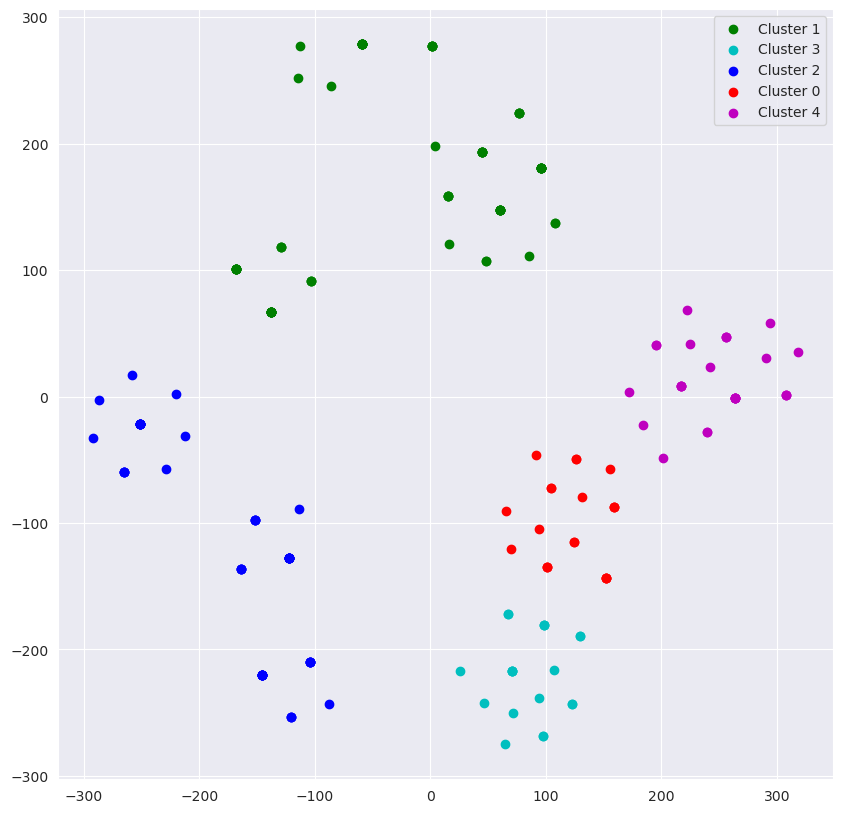

In [84]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Use o algoritmo t-SNE para reduzir a dimensionalidade dos seus dados para 2
tsne = TSNE(n_components=2)
user_ratings_2d = tsne.fit_transform(user_ratings)

# Crie um DataFrame com os resultados
df_tsne = pd.DataFrame(data=user_ratings_2d, columns=['Componente 1', 'Componente 2'])
df_tsne['cluster'] = df_copy['cluster']

# Crie um gráfico de dispersão dos componentes com matplolib
plt.figure(figsize=(10,10))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for cluster in df_tsne['cluster'].unique():
    subset = df_tsne[df_tsne['cluster'] == cluster]
    plt.scatter(subset['Componente 1'], subset['Componente 2'], c = colors[cluster], label = f'Cluster {cluster}')
plt.legend()
plt.show()

In [112]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Crie uma cópia do DataFrame para evitar modificar o DataFrame original
df_copy = laptops_df.copy()

# Transforme as marcas em números
le = LabelEncoder()
df_copy.loc[:, 'brand'] = le.fit_transform(df_copy['brand'])

# Selecione as colunas que você quer usar para o agrupamento
brand_ratings = df_copy[['brand', 'rating_float', 'discount_price']]

# Escolha o número de clusters (por exemplo, 5)
kmeans = KMeans(n_clusters=9)

# Ajuste o modelo aos dados
kmeans.fit(brand_ratings)

# Obtenha os rótulos dos clusters para cada marca
df_copy['cluster'] = kmeans.labels_


In [113]:
# Use o algoritmo t-SNE para reduzir a dimensionalidade dos seus dados para 2
tsne = TSNE(n_components=2)
brand_ratings_2d = tsne.fit_transform(brand_ratings)

In [114]:
# Crie um DataFrame com os resultados
df_tsne = pd.DataFrame(data=brand_ratings_2d, columns=['Componente 1', 'Componente 2'])
df_tsne['cluster'] = df_copy['cluster']
df_tsne['brand'] = df_copy['brand']

Botei esse código mas não sei o que ele significa SOSSSSSSSSSSSS (sei que tem alguma coisa a ver com as métricas passadas em brand_ratings e com as marcas, mas queria que o gráfico plotado pudesse identificar qual cluster corresponde a cada marca e exibisse isso na legenda).

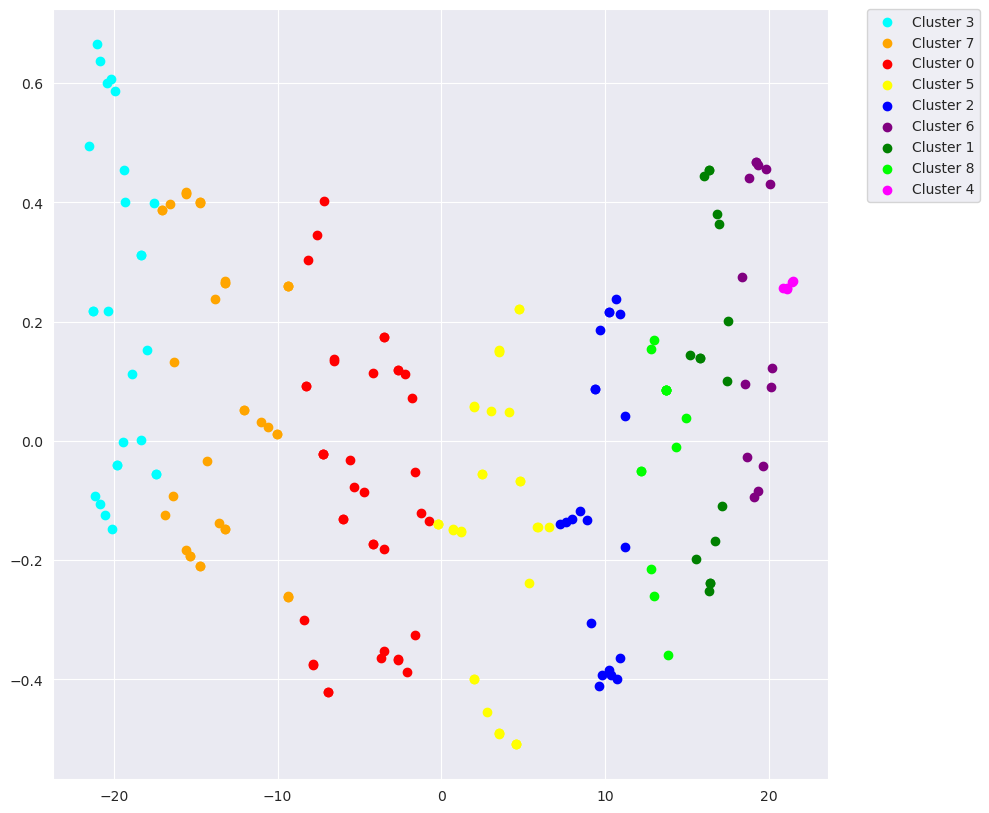

In [115]:
# Crie um gráfico de dispersão dos componentes com matplolib
plt.figure(figsize=(10,10))

# Defina uma lista de cores vivas
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'purple', 'orange', 'lime', 'pink']

for cluster in df_tsne['cluster'].unique():
    subset = df_tsne[df_tsne['cluster'] == cluster]
    plt.scatter(subset['Componente 1'], subset['Componente 2'], c = colors[cluster], label = f'Cluster {cluster}')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()